In [53]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mssmartypants/rice-type-classification")

Skipping, found downloaded files in "./rice-type-classification" (use force=True to force download)


In [54]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader ,Dataset
from torchsummary import summary
from sklearn.model_selection import train_test_split # Split the dataset (train, validation, test)
from sklearn.metrics import accuracy_score # Calculate the testing Accuracy
import matplotlib.pyplot as plt # Plotting the training progress at the end
import pandas as pd # Data reading and preprocessing
import numpy as np # Mathematical operations


In [55]:
import random
def set_seeds(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seeds(42)

In [56]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [57]:
data_df=pd.read_csv("/content/rice-type-classification/riceClassification.csv")
data_df.dropna(inplace=True)
data_df.drop(["id"] , axis=1 ,inplace=True)
print("Output possibilities: ", data_df["Class"].unique()) # Possible Outputs
print("Data Shape (rows, cols): ", data_df.shape) # Print data shape
data_df.head()


Output possibilities:  [1 0]
Data Shape (rows, cols):  (18185, 11)


,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


Normalize the data

In [58]:
data_df.shape

(18185, 11)

In [59]:
data_df.Class.value_counts()

,count
Class,
1,9985
0,8200


In [60]:
data_df.iloc[0]

,0
Area,4537.000000
MajorAxisLength,92.229316
MinorAxisLength,64.012769
Eccentricity,0.719916
ConvexArea,4677.000000
EquivDiameter,76.004525
Extent,0.657536
Perimeter,273.085000
Roundness,0.764510
AspectRation,1.440796


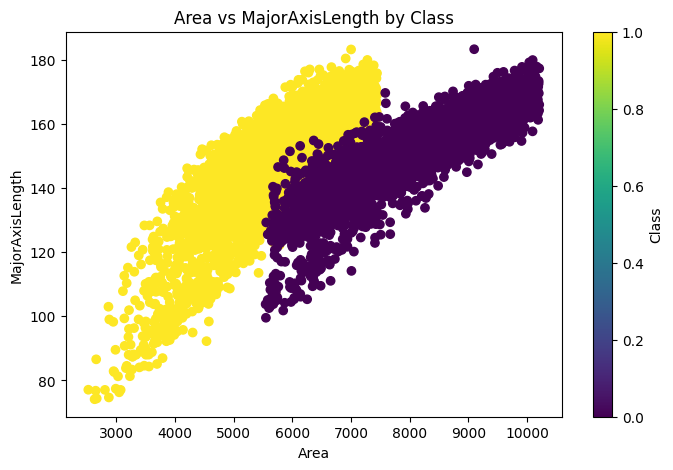

In [61]:
# Example: Scatter plot of Area vs. MajorAxisLength colored by Class
plt.figure(figsize=(8, 5))
plt.scatter(data_df['Area'], data_df['MajorAxisLength'], c=data_df['Class'], cmap='viridis')
plt.xlabel('Area')
plt.ylabel('MajorAxisLength')
plt.title('Area vs MajorAxisLength by Class')
plt.colorbar(label='Class')
plt.show()

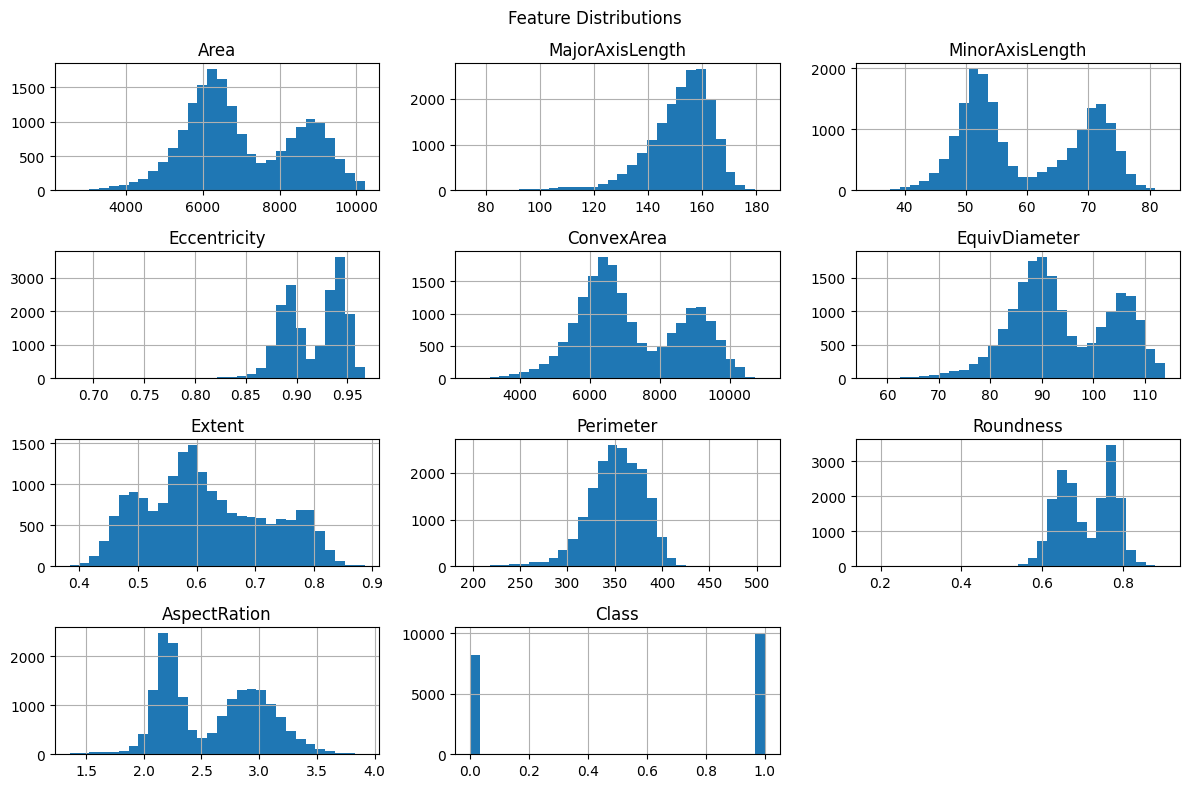

In [62]:
import matplotlib.pyplot as plt

# Plot histograms for all features
data_df.hist(bins=30, figsize=(12, 8))
plt.suptitle("Feature Distributions")
plt.tight_layout()
plt.show()

In [63]:
from sklearn.preprocessing import StandardScaler

# Split FIRST, then normalize
X = np.array(data_df.iloc[:,:-1])
Y = np.array(data_df.iloc[:,-1])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


split data

Training Size 70%

Validation Size 15%

Testing Size 15%

In [64]:
class dataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype = torch.float32).to(device)
        self.Y = torch.tensor(Y, dtype = torch.float32).to(device)

    def __len__(self):
        return len(self.X)
    def __getitem__(self, index):
        return self.X[index], self.Y[index]

training_data = dataset(X_train, y_train)
validation_data = dataset(X_val, y_val)
testing_data = dataset(X_test, y_test)

In [65]:
BATCH_SIZE = 64
EPOCHS = 100
HIDDEN_NEURONS = 10
LR =0.001

In [66]:
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle= True)
validation_dataloader = DataLoader(validation_data, batch_size=BATCH_SIZE, shuffle= True)
testing_dataloader = DataLoader(testing_data, batch_size=BATCH_SIZE, shuffle= True)


In [67]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(X.shape[1], HIDDEN_NEURONS)
        self.bn1 = nn.BatchNorm1d(HIDDEN_NEURONS)
        self.layer_2 = nn.Linear(HIDDEN_NEURONS, HIDDEN_NEURONS)
        self.bn2 = nn.BatchNorm1d(HIDDEN_NEURONS)
        self.layer_3 = nn.Linear(HIDDEN_NEURONS, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.dropout(self.relu(self.bn1(self.layer_1(x))))
        x = self.dropout(self.relu(self.bn2(self.layer_2(x))))
        return self.layer_3(x)

model = MyModel().to(device)
print(model)


MyModel(
  (layer_1): Linear(in_features=10, out_features=10, bias=True)
  (bn1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (bn2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)


Params=(number of inputs×number of outputs)+number of outputs (biases)




When you create:

**nn.Linear(in_features, out_features)**

PyTorch automatically includes:

**Weights: shape → (out_features, in_features)**

**Bias: shape → (out_features,) (one bias per output neuron)**

Unless you set bias=False, every output neuron has exactly one bias term

In [68]:

model = MyModel().to(device)
summary(model, (X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
       BatchNorm1d-2                   [-1, 10]              20
              ReLU-3                   [-1, 10]               0
           Dropout-4                   [-1, 10]               0
            Linear-5                   [-1, 10]             110
       BatchNorm1d-6                   [-1, 10]              20
              ReLU-7                   [-1, 10]               0
           Dropout-8                   [-1, 10]               0
            Linear-9                    [-1, 1]              11
Total params: 271
Trainable params: 271
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
---------------------------------------------------

In [69]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)

# ADD THIS LINE:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5)


In [70]:
total_loss_train = []
total_loss_val = []
total_acc_train = []
total_acc_val = []

# Early stopping variables
best_val_acc = 0
patience_counter = 0
patience = 20

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_preds = []
    train_labels = []
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.float()
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        preds = (torch.sigmoid(outputs) > 0.5).float().cpu().numpy()
        train_preds.extend(preds)
        train_labels.extend(labels.cpu().numpy())

    train_loss /= len(train_dataloader)
    train_acc = accuracy_score(train_labels, train_preds)
    total_loss_train.append(train_loss)
    total_acc_train.append(train_acc)

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_preds = []
    val_labels = []
    with torch.no_grad():
        for inputs, labels in validation_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.float()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).float().cpu().numpy()
            val_preds.extend(preds)
            val_labels.extend(labels.cpu().numpy())

    val_loss /= len(validation_dataloader)
    val_acc = accuracy_score(val_labels, val_preds)
    total_loss_val.append(val_loss)
    total_acc_val.append(val_acc)

    # ADD THESE LINES FOR LEARNING RATE SCHEDULING AND EARLY STOPPING:
    scheduler.step(val_loss)  # Update learning rate

    # Early stopping logic
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Save best model
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, LR: {current_lr:.6f}')

# 5. LOAD BEST MODEL FOR FINAL TESTING (add before your testing section):
model.load_state_dict(torch.load('best_model.pth'))
print(f"Loaded best model with validation accuracy: {best_val_acc:.4f}")

Epoch 10/100, Train Loss: 0.0729, Train Acc: 0.9799, Val Loss: 0.0392, Val Acc: 0.9879, LR: 0.001000
Epoch 20/100, Train Loss: 0.0663, Train Acc: 0.9818, Val Loss: 0.0382, Val Acc: 0.9872, LR: 0.001000
Epoch 30/100, Train Loss: 0.0636, Train Acc: 0.9804, Val Loss: 0.0391, Val Acc: 0.9883, LR: 0.001000
Early stopping at epoch 34
Loaded best model with validation accuracy: 0.9886


In [71]:
def predict_single_row(model, row, device):
    model.eval()
    with torch.no_grad():
        if isinstance(row, torch.Tensor):
            row_tensor = row.clone().detach().to(device).unsqueeze(0)
        else:
            row_tensor = torch.tensor(row, dtype=torch.float32).to(device).unsqueeze(0)

        output = model(row_tensor)

        # Binary classification case
        predicted_class = torch.round(torch.sigmoid(output)).item()
    return predicted_class


In [72]:
# Pick a row and its true label
row = X_test[0]  # first row from test set
true_label = y_test[0].item()

# Predict
predicted = predict_single_row(model, row, device)

print(f"True label: {true_label}")
print(f"Predicted label: {predicted}")


True label: 1
Predicted label: 1.0


In [73]:
### TESTING ###
model.eval()
total_loss_test = 0
total_acc_test = 0

with torch.inference_mode():
    for inputs, labels in testing_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        y_logits = model(inputs).squeeze(1)
        y_pred = torch.round(torch.sigmoid(y_logits))

        # Loss
        loss = criterion(y_logits, labels)
        total_loss_test += loss.item()

        # Accuracy
        total_acc_test += (y_pred == labels).sum().item()

# Print test results
print(f"Test Loss: {total_loss_test / len(testing_dataloader):.4f} | "
      f"Test Acc: {total_acc_test / len(testing_data) * 100:.2f}%")


Test Loss: 0.0253 | Test Acc: 99.08%


In [74]:
model.eval()
with torch.inference_mode():
    X_test_tensor = torch.FloatTensor(X_test).to(device)
    y_test_tensor = torch.FloatTensor(y_test).to(device)

    # Get logits and convert to probabilities
    logits = model(X_test_tensor)
    probabilities = torch.sigmoid(logits)
    predictions = (probabilities > 0.5).float()

    # Convert to numpy for plotting
    probs_np = probabilities.cpu().numpy().flatten()
    preds_np = predictions.cpu().numpy().flatten()
    y_test_np = y_test_tensor.cpu().numpy()

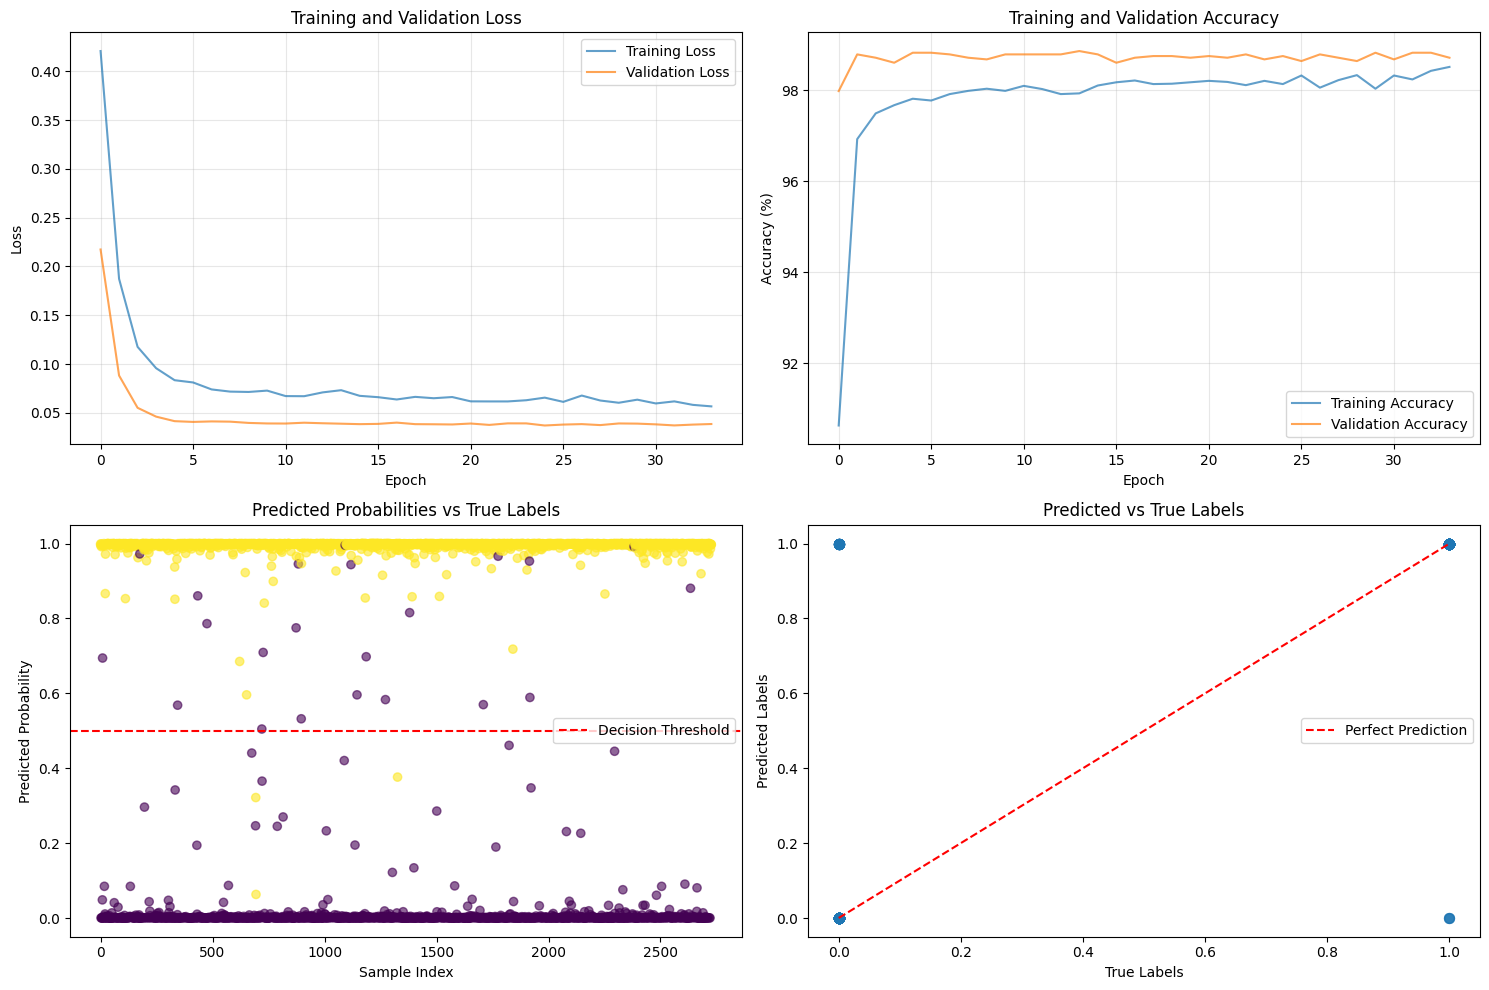

In [75]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Loss curves
axes[0,0].plot(total_loss_train, label='Training Loss', alpha=0.7)
axes[0,0].plot(total_loss_val, label='Validation Loss', alpha=0.7)
axes[0,0].set_title('Training and Validation Loss')
axes[0,0].set_xlabel('Epoch')
axes[0,0].set_ylabel('Loss')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Plot 2: Accuracy curves
axes[0,1].plot([acc*100 for acc in total_acc_train], label='Training Accuracy', alpha=0.7)
axes[0,1].plot([acc*100 for acc in total_acc_val], label='Validation Accuracy', alpha=0.7)
axes[0,1].set_title('Training and Validation Accuracy')
axes[0,1].set_xlabel('Epoch')
axes[0,1].set_ylabel('Accuracy (%)')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Plot 3: Predicted probabilities
axes[1,0].scatter(range(len(probs_np)), probs_np, c=y_test_np, alpha=0.6, cmap='viridis')
axes[1,0].axhline(y=0.5, color='red', linestyle='--', label='Decision Threshold')
axes[1,0].set_xlabel('Sample Index')
axes[1,0].set_ylabel('Predicted Probability')
axes[1,0].set_title('Predicted Probabilities vs True Labels')
axes[1,0].legend()

# Plot 4: Confusion matrix visualization
axes[1,1].scatter(y_test_np, preds_np, alpha=0.6, s=50)
axes[1,1].plot([0, 1], [0, 1], 'r--', label='Perfect Prediction')
axes[1,1].set_xlabel('True Labels')
axes[1,1].set_ylabel('Predicted Labels')
axes[1,1].set_title('Predicted vs True Labels')
axes[1,1].legend()

plt.tight_layout()
plt.show()

In [76]:
final_accuracy = accuracy_score(y_test_np, preds_np)
print(f"Final Test Accuracy: {final_accuracy:.4f} ({final_accuracy*100:.2f}%)")

Final Test Accuracy: 0.9908 (99.08%)


In [77]:
import torch

# 1. Take one sample from your dataset
single_row = X_test_tensor[0]  # first row
true_label = y_test_tensor[0]  # correct label

# 2. Add batch dimension (model expects [batch_size, features])
single_row = single_row.unsqueeze(0)

# 3. Put model in evaluation mode and disable gradients
model.eval()
with torch.inference_mode():
    pred_logits = model(single_row)  # raw output (logits)
    pred_prob = torch.sigmoid(pred_logits)  # convert to probability for binary classification
    pred_class = torch.round(pred_prob)  # 0 or 1

# 4. Show result
print(f"True label: {true_label.item()}")
print(f"Predicted probability: {pred_prob.item():.4f}")
print(f"Predicted class: {int(pred_class.item())}")


True label: 1.0
Predicted probability: 0.9986
Predicted class: 1


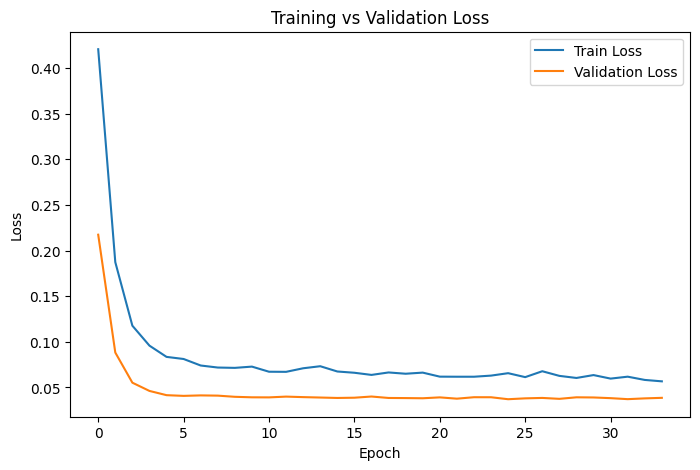

In [78]:
plt.figure(figsize=(8,5))
plt.plot(total_loss_train, label='Train Loss')
plt.plot(total_loss_val, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()
